In [81]:
# importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
import joblib    
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import  KFold



In [82]:
# Load the CSV file with setting an index

df = pd.read_csv('H1N1_Flu_Vaccines.csv', index_col='respondent_id')

In [83]:
# viewing all our columns 

pd.set_option('display.max_columns', 100)


## <span style= 'color : cyan'>  Data Cleaning </span>

In [86]:
# getting the shape of our data

print('rows :', df.shape[0])
print('columns :', df.shape[1])


rows : 26707
columns : 37


#### `checking for duplicate values`

In [87]:
# checking for duplicated values

print ('duplicated :' , df.duplicated().sum())

duplicated : 0


#### `checking for null values`

In [88]:
df.isna().sum().sort_values(ascending = False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_seasonal            2160
doctor_recc_h1n1                2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

#### `handling null values`

To handle our null values wwe will use the simple imputer

* Data was split to categorical and numerical values
  #
* Each split is treated differently with numerical columns we used *`most frequent`* since this will preserve the overall distribution of categorical data
  #
* Categorical columns we used *`most frequent`* as the strategy since most of our values are repetitive classes

In [89]:
# Handling null values

data_num = df.select_dtypes(exclude= 'object')

# instantiate imputer

imputer = SimpleImputer(missing_values= np.nan, strategy= 'most_frequent')

# fit and transform our numerical values

data_num.iloc[:,:] = imputer.fit_transform(data_num)


In [90]:
# instantiate imputer

imputer2 = SimpleImputer(missing_values= np.nan, strategy= 'most_frequent')

data_cat =df.select_dtypes(include= 'object')

# fit and transform our categorical values

data_cat.iloc[:,:] = imputer2.fit_transform(data_cat)


#### `Encoding our data using Ordical Encoder`

* For encoding *`Ordinal Encoder`* is suitable for our data set since our values have no specific order
 #
* That is there is no hierarchical relationship in our features values

In [91]:
from sklearn.preprocessing import OrdinalEncoder

# Create an instance of the OrdinalEncoder

encoder = OrdinalEncoder()

# Fitting , transforming and passing it into a data frame

X_encoded_df = pd.DataFrame(encoder.fit_transform(data_cat))

# Naming our columns

X_encoded_df.columns = data_cat.columns


#### `Concatenating the data frames into one data frame called  new_df`

In [92]:
new_df  = pd.concat([data_num, X_encoded_df], axis =1)


## <span style = 'color : cyan' > EXPLORATORY DATA ANALYSIS </span>


### <span style = 'color : orange' > 1. UNIVARIATE ANALYSIS OF OUR CATEGORICAL FEATURES </span>


This is to show the distribution of our features and which groups are highly or less represented in our data set

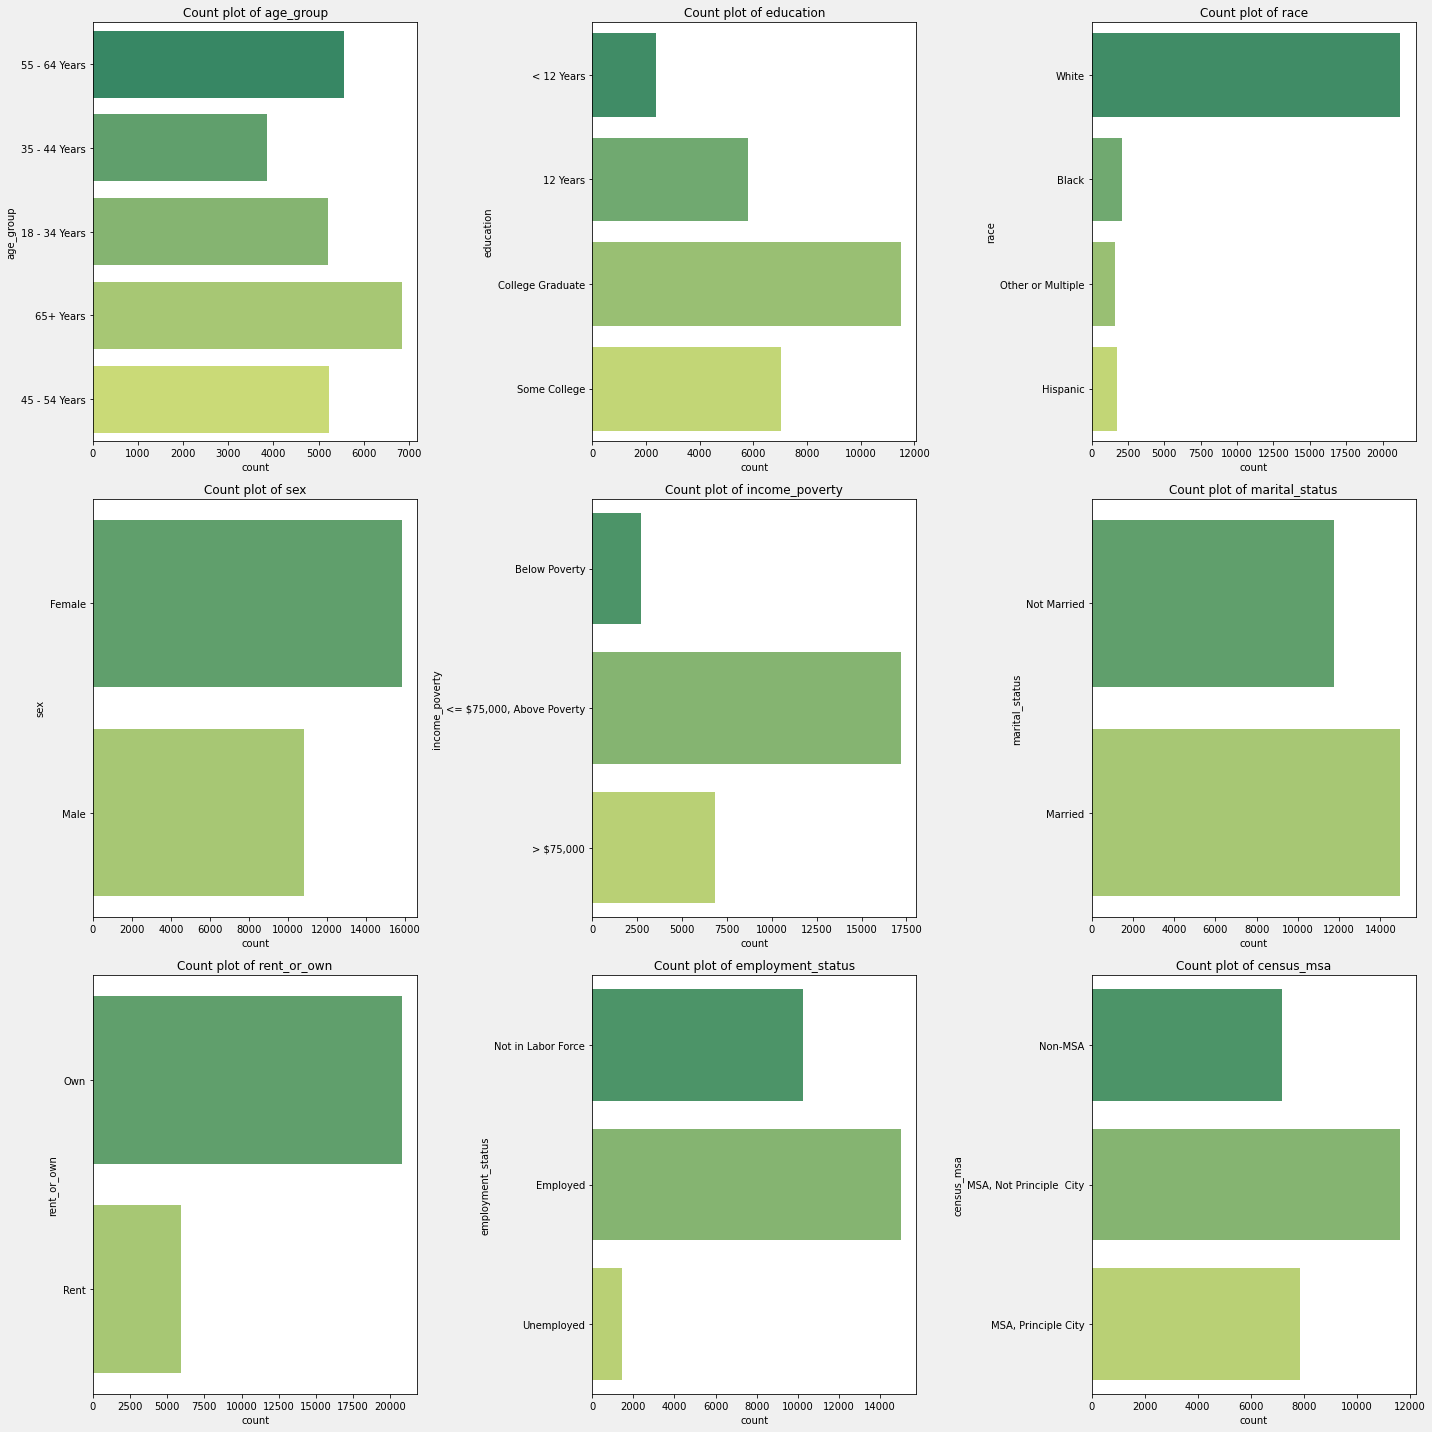

In [93]:
# dropping the columns that will not be used for this visualization

data_cat = data_cat.drop(['employment_industry', 'employment_occupation', 'hhs_geo_region'], axis=1)

#getting the columns for the plot

count_plot = data_cat.columns

# Setting the  size and axes of my visualization

fig, axes = plt.subplots(nrows=3 , ncols=3, figsize=(20, 20))

fig.patch.set_facecolor('#F0F0F0') 

# Iterate over the columns and corresponding axes
for column, ax in zip(count_plot, axes.flatten()):
    sns.countplot(data=data_cat, y=column, ax=ax, palette="summer")
    ax.set_title(f'Count plot of {column}')

# plotting the graph

plt.tight_layout()
plt.show()

## `choose seasonal_vaccine coz h1n1 is imbalanced`

In [94]:

# Create subplots with titles
fig = make_subplots(rows=3, cols=3, subplot_titles=('Race', 'Sex', 'Education', 'Age Group', 'Marital Status', 'HHS Geo Region', 'Health Worker', 'Health Insurance'))

# Define variables and titles
variables = ['race', 'sex', 'education', 'age_group', 'marital_status', 'hhs_geo_region', 'health_worker', 'health_insurance']
titles = ['Race', 'Sex', 'Education', 'Age Group', 'Marital Status', 'HHS Geo Region', 'Health Worker', 'Health Insurance']

# Loop through the variables and add violin plots to the subplots
for i, var in enumerate(variables):
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.add_trace(go.Violin(x=df[var], y=df['seasonal_vaccine'], name=titles[i]), row=row, col=col)

# Update the layout
fig.update_layout(height=1100, width=1100, title_text="Violin Subplots", template="simple_white")

# Show the figure
fig.show()

#### `Getting the best Features for our  models using chi2 `

In [96]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x = new_df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = new_df['seasonal_vaccine']

In [97]:
# apply select k best to extract best features

best_features = SelectKBest(chi2, k=15)

fit = best_features.fit(x,y)

scores = pd.DataFrame([])

# fit the

In [98]:
# Importing necessary modules for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Set the Target and Independent variable

X = new_df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1) # Independent Variable
y = new_df.seasonal_vaccine # Target Variable

# Apply select K best to extract best features 
best_features = SelectKBest(chi2,k=15)
fit = best_features.fit(X, y)

scores = pd.DataFrame(fit.scores_)
x_columns= pd.DataFrame(X.columns)

feature_score = pd.concat([x_columns,scores], axis=1)
feature_score.columns =['feature_data1','scores']
feature_score

feature_data1       scores
0                  h1n1_concern   325.148276
1                h1n1_knowledge   115.652237
2     behavioral_antiviral_meds     0.918545
3          behavioral_avoidance    42.141343
4          behavioral_face_mask    62.214095
5         behavioral_wash_hands    58.594846
6   behavioral_large_gatherings    69.677957
7       behavioral_outside_home    50.332544
8         behavioral_touch_face   123.369866
9              doctor_recc_h1n1   839.733852
10         doctor_recc_seasonal  2421.579654
11        chronic_med_condition   557.625394
12         child_under_6_months     4.427147
13                health_worker   383.862558
14             health_insurance    27.094311
15  opinion_h1n1_vacc_effective   286.280388
16            opinion_h1n1_risk   866.169464
17  opinion_h1n1_sick_from_vacc    16.260163
18  opinion_seas_vacc_effective   991.273021
19            opinion_seas_risk  2794.888237
20  opinion_seas_sick_from_vacc    73.276237
21             household_adults    71.806568
22           household_children   538.442999
23                    age_group  1997.217625
24                    education     5.762772
25                         race    91.674338
26                          sex    94.243768
27               income_poverty    38.808131
28               marital_status    26.849772
29                  rent_or_own   215.311327
30            employment_status    67.380193
31               hhs_geo_region    14.872176
32                   census_msa     7.253763
33          employment_industry  1669.849661
34        employment_occupation     7.185226

In [99]:
final_features = feature_score.nlargest(20, 'scores')

In [100]:
# final features

final_features

feature_data1       scores
19            opinion_seas_risk  2794.888237
10         doctor_recc_seasonal  2421.579654
23                    age_group  1997.217625
33          employment_industry  1669.849661
18  opinion_seas_vacc_effective   991.273021
16            opinion_h1n1_risk   866.169464
9              doctor_recc_h1n1   839.733852
11        chronic_med_condition   557.625394
22           household_children   538.442999
13                health_worker   383.862558
0                  h1n1_concern   325.148276
15  opinion_h1n1_vacc_effective   286.280388
29                  rent_or_own   215.311327
8         behavioral_touch_face   123.369866
1                h1n1_knowledge   115.652237
26                          sex    94.243768
25                         race    91.674338
20  opinion_seas_sick_from_vacc    73.276237
21             household_adults    71.806568
6   behavioral_large_gatherings    69.677957

In [101]:
# selecting features

columns_to_include = final_features['feature_data1'].tolist()

In [102]:
columns_to_include.append('seasonal_vaccine')


In [103]:
columns_to_include

['opinion_seas_risk',
 'doctor_recc_seasonal',
 'age_group',
 'employment_industry',
 'opinion_seas_vacc_effective',
 'opinion_h1n1_risk',
 'doctor_recc_h1n1',
 'chronic_med_condition',
 'household_children',
 'health_worker',
 'h1n1_concern',
 'opinion_h1n1_vacc_effective',
 'rent_or_own',
 'behavioral_touch_face',
 'h1n1_knowledge',
 'sex',
 'race',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'behavioral_large_gatherings',
 'seasonal_vaccine']

In [104]:
final_df = new_df[columns_to_include]


In [105]:
final_df.head()

opinion_seas_risk  doctor_recc_seasonal  age_group  employment_industry  \
0                1.0                   0.0        3.0                  4.0   
1                2.0                   0.0        1.0                 12.0   
2                1.0                   0.0        0.0                 14.0   
3                4.0                   1.0        4.0                  4.0   
4                1.0                   0.0        2.0                 18.0   

   opinion_seas_vacc_effective  opinion_h1n1_risk  doctor_recc_h1n1  \
0                          2.0                1.0               0.0   
1                          4.0                4.0               0.0   
2                          4.0                1.0               0.0   
3                          5.0                3.0               0.0   
4                          3.0                3.0               0.0   

   chronic_med_condition  household_children  health_worker  h1n1_concern  \
0                    0.0                 0.0            0.0           1.0   
1                    0.0                 0.0            0.0           3.0   
2                    1.0                 0.0            0.0           1.0   
3                    1.0                 0.0            0.0           1.0   
4                    0.0                 0.0            0.0           2.0   

   opinion_h1n1_vacc_effective  rent_or_own  behavioral_touch_face  \
0                          3.0          0.0                    1.0   
1                          5.0          1.0                    1.0   
2                          3.0          0.0                    0.0   
3                          3.0          1.0                    0.0   
4                          3.0          0.0                    1.0   

   h1n1_knowledge  sex  race  opinion_seas_sick_from_vacc  household_adults  \
0             0.0  0.0   3.0                          2.0               0.0   
1             2.0  1.0   3.0                          4.0               0.0   
2             1.0  1.0   3.0                          2.0               2.0   
3             1.0  0.0   3.0                          1.0               0.0   
4             1.0  0.0   3.0                          4.0               1.0   

   behavioral_large_gatherings  seasonal_vaccine  
0                          0.0               0.0  
1                          0.0               1.0  
2                          0.0               0.0  
3                          1.0               1.0  
4                          1.0               0.0

In [106]:
# this is our final data frame

final_df.shape

(26707, 21)

## `BASE MODEL`

### DECISION TREE

In [107]:
X = final_df.drop('seasonal_vaccine', axis=1)
Y= final_df['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, stratify=Y, random_state=0)

Testing time: 2.053140878677368 seconds
Model Train accuracy: 0.997
Model Test accuracy: 0.681
Cross Validation Accuracy: 67.9756%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70      2855
         1.0       0.66      0.67      0.66      2487

    accuracy                           0.68      5342
   macro avg       0.68      0.68      0.68      5342
weighted avg       0.68      0.68      0.68      5342



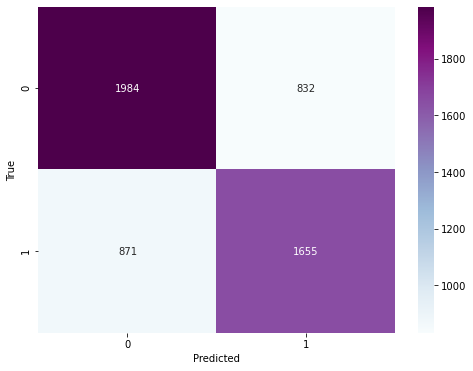

In [108]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# setting my pipeline

scaled_pipeline = Pipeline([('scaler' , StandardScaler()),
                            ('tree', DecisionTreeClassifier())])
cv = 10
# setting basic parameter
grid = [{'tree__criterion': ['entropy'], 
         }]

gridsearch = GridSearchCV(estimator=scaled_pipeline, 
                          param_grid= grid,
                          scoring='accuracy', 
                          cv=cv)

# training and fitting
import time

def fit_train_score(model):
    
    start_time = time.time()
    
    model.fit(X_train,y_train)

    # predicting with X_test

    y_test_pred = model.predict(X_test)

    #accuracy score of the model on the training set.

    y_train_pred = model.predict(X_train)
    
    # End the timer
    
    end_time = time.time()

    #accuracy score of the model on the training set.

    accuracy_train = accuracy_score(y_train_pred,y_train)

    # the accuracy score of the model on the test set.

    accuracy_test = accuracy_score(y_test_pred, y_test)
    
    # performing cross validation
    cross_val = cross_val_score(model,X_train,y_train,cv = cv)
    
    # Calculate the elapsed time
    
    elapsed_time = end_time - start_time
    
    # Calculate the elapsed time
    
    print(f"Testing time: {elapsed_time} seconds")
    
    # Printing the scores
    print(f'Model Train accuracy: {accuracy_train:.3f}')
    print(f'Model Test accuracy: {accuracy_test:.3f}')
    print(f"Cross Validation Accuracy: {round(cross_val.mean()*100,4)}%")
    
    # creating confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_test_pred)
    
    # Making the Confusion Matrix
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(y_test_pred, y_test)
    
    ax = sns.heatmap(cm,annot=True, fmt= 'd', cmap = 'BuPu')
    
     # Add labels to the x and y axes
     
    ax.set_xlabel('Predicted')
    
    ax.set_ylabel('True')
   
    plt.savefig('confusion.png')
    
    print('\n')
    
    print ('***********************************', '\n')
    
    # printing the report
    
    print(classification_report(y_test, y_test_pred))

    
    
def learning_curve(model):
    
    # Plotting the learning curve
    
    from sklearn.model_selection import  learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring='accuracy')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation score')
    plt.fill_between(
        train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
        

fit_train_score(gridsearch)

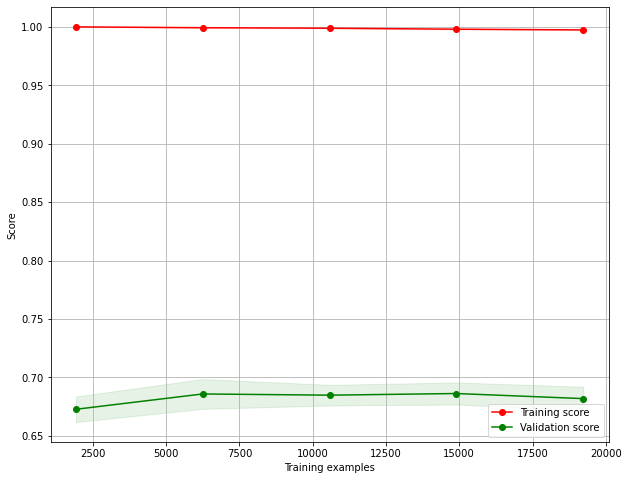

In [30]:
# plotting the learning curve

learning_curve(gridsearch)

### <span style ='color : orange ' > Random Forest Classifier </span>

Testing time: 77.5652916431427 seconds
Model Train accuracy: 0.777
Model Test accuracy: 0.779
Cross Validation Accuracy: 76.9015%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      2855
         1.0       0.78      0.73      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



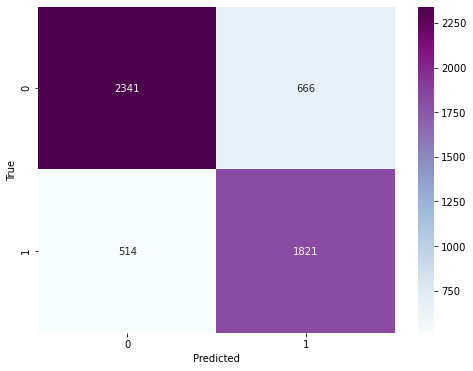

In [109]:
# importing the necessary library

from sklearn.ensemble import RandomForestClassifier

# defining our pipeline

scaled_pipeline1 = Pipeline([('scaler' , StandardScaler()),
                            ('tree1', RandomForestClassifier())])
# setting our cv

cv= 6

# setting basic parameter

grid = [{'tree1__n_estimators' : [len(range(1,120))],
         'tree1__criterion': ['gini', 'entropy'],
         'tree1__max_depth': [2,3,4,5,6]}]

# Setting up the grid search

gridsearch1 = GridSearchCV(estimator=scaled_pipeline1, 
                          param_grid= grid,
                          scoring='accuracy', 
                          cv=cv)

fit_train_score(gridsearch1)

In [110]:
# getting the best parameters of the random tree classifier

gridsearch1.best_params_

{'tree1__criterion': 'gini', 'tree1__max_depth': 6, 'tree1__n_estimators': 119}

### <span style ='color : orange ' > Random Forest Classifier with best parameters</span>

Testing time: 14.120187520980835 seconds
Model Train accuracy: 0.777
Model Test accuracy: 0.776
Cross Validation Accuracy: 76.9483%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      2855
         1.0       0.78      0.73      0.75      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



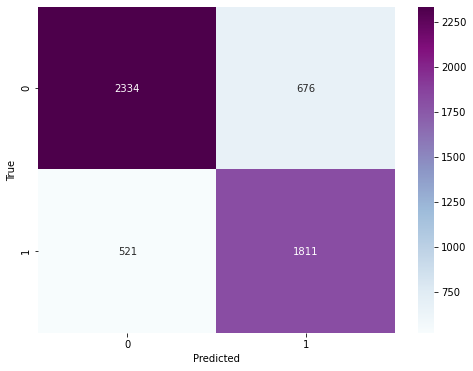

In [111]:
# setting the best parameters for our random tree classifier

grid = [{'tree1__n_estimators' : [119],
         'tree1__criterion': ['gini'],
         'tree1__max_depth': [6]}]

# setting the cv to 5

cv= 6

# setting the grid search 

gridsearch1 = GridSearchCV(estimator=scaled_pipeline1, 
                          param_grid= grid,
                          scoring='accuracy', 
                          cv=cv)

# training and fitting the model

fit_train_score(gridsearch1)

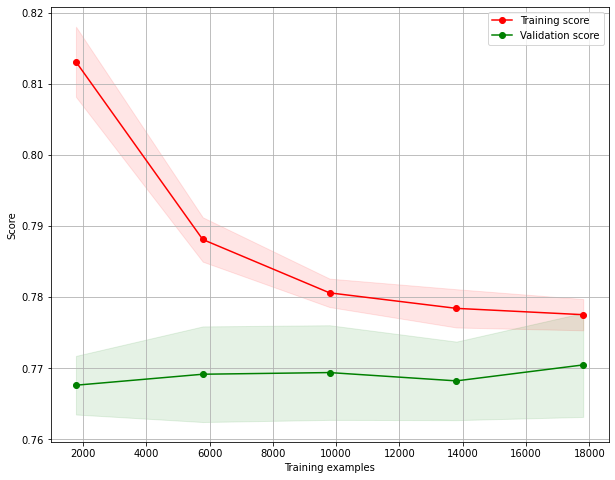

In [112]:
# plotting the learning curve

learning_curve(gridsearch1)

### <span style ='color : orange ' > Gradient Boosting Classifier</span>

Testing time: 17.58219051361084 seconds
Model Train accuracy: 0.780
Model Test accuracy: 0.776
Cross Validation Accuracy: 77.7159%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79      2855
         1.0       0.77      0.75      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



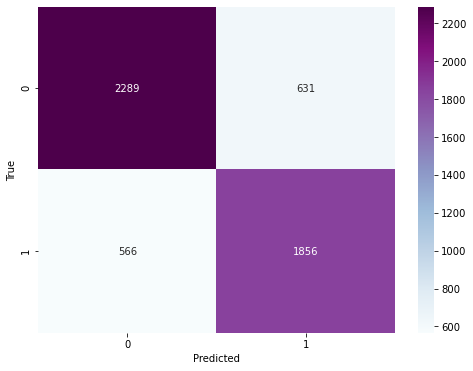

In [113]:
# importing the required module

from sklearn.ensemble import GradientBoostingClassifier

# initializing the pipeline

scaled_pipeline2 = Pipeline([('scaler' , StandardScaler()),
                            ('gradient', GradientBoostingClassifier())])

cv= 5
# setting basic parameter
grid2 = [{'gradient__loss' : ['log_loss', 'deviance'],
         'gradient__learning_rate': [0.1, 0.2, 0.3],
         'gradient__n_estimators': [len(range(80,100))]}]

gridsearch2 = GridSearchCV(estimator=scaled_pipeline2, 
                          param_grid= grid2,
                          scoring='accuracy', 
                          cv=cv)

fit_train_score(gridsearch2)

In [114]:
gridsearch2.best_params_

{'gradient__learning_rate': 0.3,
 'gradient__loss': 'log_loss',
 'gradient__n_estimators': 20}

### <span style ='color : orange ' > Gradient Boosting Classifier with best parameters</span>

Testing time: 3.822035312652588 seconds
Model Train accuracy: 0.780
Model Test accuracy: 0.776
Cross Validation Accuracy: 77.7159%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79      2855
         1.0       0.77      0.75      0.76      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



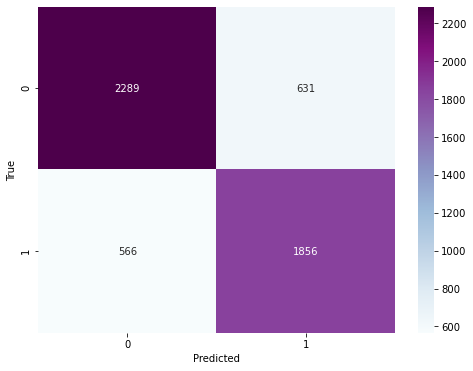

In [115]:
# setting the cv

cv= 5

# setting best parameters

grid2 = [{'gradient__loss' : ['log_loss'],
         'gradient__learning_rate': [0.3],
         'gradient__n_estimators': [20]}]

# setting the grid search

gridsearch_best = GridSearchCV(estimator=scaled_pipeline2, 
                          param_grid= grid2,
                          scoring='accuracy', 
                          cv=cv)

# fitting and training the model

fit_train_score(gridsearch_best)

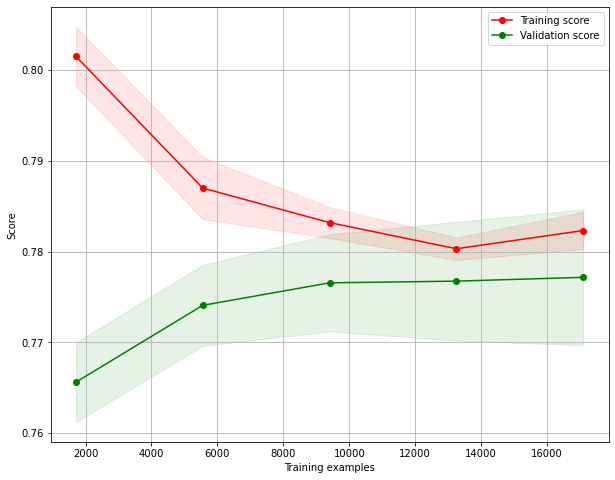

In [116]:
# plotting the learning curve

learning_curve(gridsearch_best)

### <span style ='color : orange ' > ADABoost Classifier</span>

Testing time: 7.947823762893677 seconds
Model Train accuracy: 0.767
Model Test accuracy: 0.773
Cross Validation Accuracy: 76.5926%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.77      0.82      0.80      2855
         1.0       0.78      0.72      0.75      2487

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



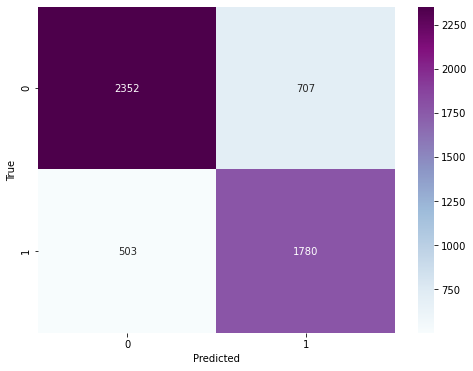

In [117]:
# ADA BOOSTING

from sklearn.ensemble import AdaBoostClassifier

# setting the pipeline

scaled_pipeline3 = Pipeline([('scaler' , StandardScaler()),
                            ('ADA', AdaBoostClassifier())])

# setting basic parameter
ada = [{'ADA__learning_rate': [0.2, 0.3, 0.4, 0.5],
         'ADA__n_estimators': [len(range(80,95))]}]

adaboost = GridSearchCV(estimator=scaled_pipeline3, 
                          param_grid= ada,
                          scoring='accuracy', 
                          cv=6)

fit_train_score(adaboost)


In [118]:
adaboost.best_params_

{'ADA__learning_rate': 0.5, 'ADA__n_estimators': 15}

### <span style ='color : orange ' > ADABoost Classifier with best parameters</span>

Testing time: 3.437588691711426 seconds
Model Train accuracy: 0.767
Model Test accuracy: 0.773
Cross Validation Accuracy: 76.5926%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.77      0.82      0.80      2855
         1.0       0.78      0.72      0.75      2487

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



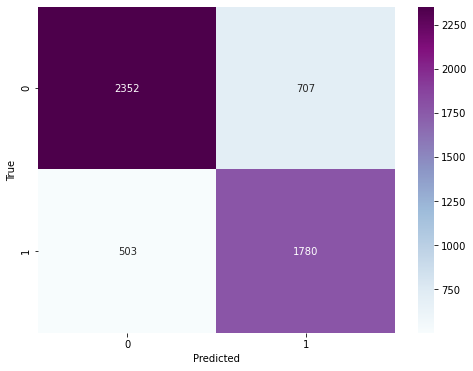

In [119]:
# setting best parameter

ada2 = [{'ADA__learning_rate': [0.5],
         'ADA__n_estimators': [15]}]

# setting the gridsearch

adaboost_best = GridSearchCV(estimator=scaled_pipeline3, 
                          param_grid= ada2,
                          scoring='accuracy', 
                          cv=6)

fit_train_score(adaboost_best)

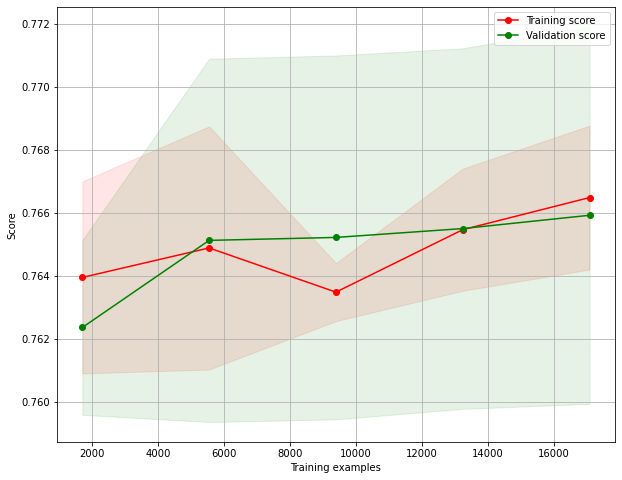

In [120]:
# plotting the learning curve

learning_curve(adaboost_best)

### <span style ='color : orange ' > XGBoost Classifier</span>

Testing time: 121.89072561264038 seconds
Model Train accuracy: 0.770
Model Test accuracy: 0.776
Cross Validation Accuracy: 76.8172%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      2855
         1.0       0.77      0.74      0.75      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



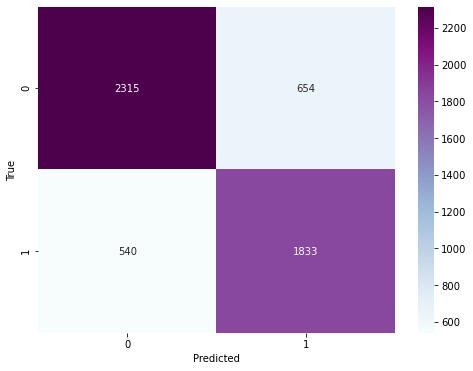

In [121]:

# setting up the pipeline

scaled_pipeline4 = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier())])

# Setting up the parameter grid for a grid search:

xgb = [{'xgb__eta': [0.2, 0.3],
         'xgb__gamma': [48,49, 50],
         'xgb__max_depth': [5],
         'xgb__subsample': [0.1, 0.2, 0.3],
         'xgb__booster': ['gbtree']}]

# Performing grid search cross-validation:

xgboost1 = GridSearchCV(estimator=scaled_pipeline4, param_grid=xgb, scoring='accuracy', cv=5)

# Fitting the training data and scoring the model:
fit_train_score(xgboost1)

In [122]:
# getting the best parameters

xgboost1.best_params_

{'xgb__booster': 'gbtree',
 'xgb__eta': 0.3,
 'xgb__gamma': 48,
 'xgb__max_depth': 5,
 'xgb__subsample': 0.3}

### <span style ='color : orange ' > XGBoost Classifier with best parameters </span>

Testing time: 16.3203182220459 seconds
Model Train accuracy: 0.770
Model Test accuracy: 0.776
Cross Validation Accuracy: 76.967%


*********************************** 

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      2855
         1.0       0.77      0.74      0.75      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



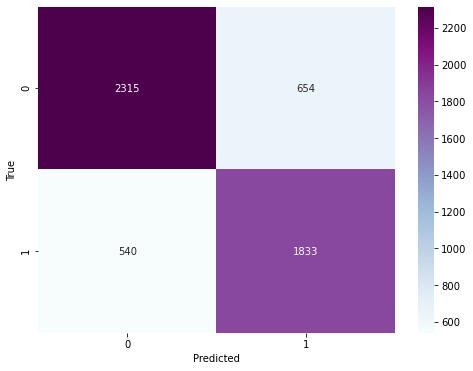

In [123]:
# Setting up the parameter grid 

xgb1 = [{'xgb__eta': [0.3],
         'xgb__gamma': [48],
         'xgb__max_depth': [5],
         'xgb__subsample': [0.3],
         'xgb__booster': ['gbtree']}]

# Performing grid search

xgboost1_best = GridSearchCV(estimator=scaled_pipeline4, param_grid=xgb1, scoring='accuracy', cv=6)

# Fitting the training data and scoring the model:
fit_train_score(xgboost1_best)

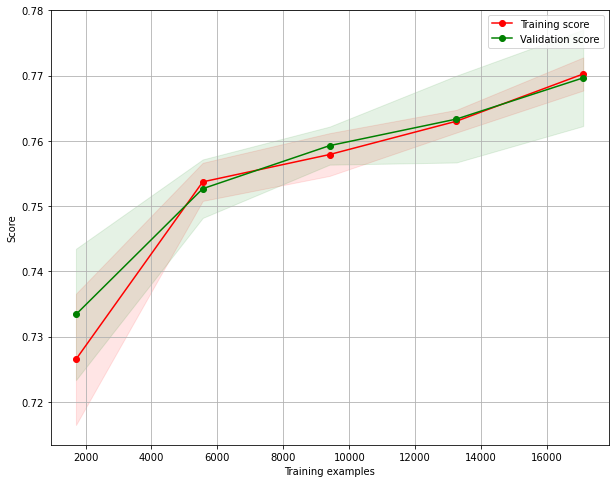

In [124]:
# plotting the learning curve

learning_curve(xgboost1_best)

### <span style ='color : orange ' > CATBoost Classifier </span>

In [ ]:
# importing the necessary libraries

from catboost import CatBoostClassifier

# setting up the pipeline

scaled_pipeline5 = Pipeline([('scaler', StandardScaler()), 
                             ('cat', CatBoostClassifier())])

# setting up the grid parameters

cat1 = [{'cat__n_estimators':[len(range(10,100))],
        'cat__eta': [0.1, 0.2, 0.3, 0.4],
        'cat__max_depth': [5, 6],
        'cat__bootstrap_type': ['Bayesian', 'Bernoulli']}]

# setting up the grid search

cat1_grid = GridSearchCV(estimator=scaled_pipeline5, param_grid= cat1, scoring='accuracy', cv=6) 

# training and testing

fit_train_score(cat1_grid)



In [126]:
cat1_grid.best_params_

{'cat__bootstrap_type': 'Bernoulli',
 'cat__eta': 0.2,
 'cat__max_depth': 5,
 'cat__n_estimators': 90}

### <span style ='color : orange ' > CATBoost Classifier with best parameters</span>

In [ ]:
# setting up the grid parameters

cat1 = [{'cat__n_estimators':[90],
        'cat__eta': [0.2],
        'cat__max_depth': [5],
        'cat__bootstrap_type': ['Bernoulli']}]

# setting up the grid search

cat1_grid_best = GridSearchCV(estimator=scaled_pipeline5, param_grid= cat1, scoring='accuracy', cv=6) 

# training and testing

fit_train_score(cat1_grid_best)

0:	learn: 0.6273719	total: 3.41ms	remaining: 303ms
1:	learn: 0.5894934	total: 6.51ms	remaining: 286ms
2:	learn: 0.5589633	total: 14.5ms	remaining: 421ms
3:	learn: 0.5409812	total: 18.9ms	remaining: 406ms
4:	learn: 0.5220468	total: 27.3ms	remaining: 463ms
5:	learn: 0.5055468	total: 30.6ms	remaining: 428ms
6:	learn: 0.4963309	total: 33.6ms	remaining: 399ms
7:	learn: 0.4873885	total: 40.6ms	remaining: 416ms
8:	learn: 0.4800427	total: 43.7ms	remaining: 393ms
9:	learn: 0.4757808	total: 46.7ms	remaining: 373ms
10:	learn: 0.4686452	total: 50.5ms	remaining: 363ms
11:	learn: 0.4613001	total: 53.9ms	remaining: 351ms
12:	learn: 0.4562509	total: 57.6ms	remaining: 341ms
13:	learn: 0.4525339	total: 62.5ms	remaining: 339ms
14:	learn: 0.4487072	total: 65.5ms	remaining: 327ms
15:	learn: 0.4439058	total: 68.5ms	remaining: 317ms
16:	learn: 0.4407858	total: 72.7ms	remaining: 312ms
17:	learn: 0.4363255	total: 76ms	remaining: 304ms
18:	learn: 0.4311083	total: 79.1ms	remaining: 296ms
19:	learn: 0.4255126	tot

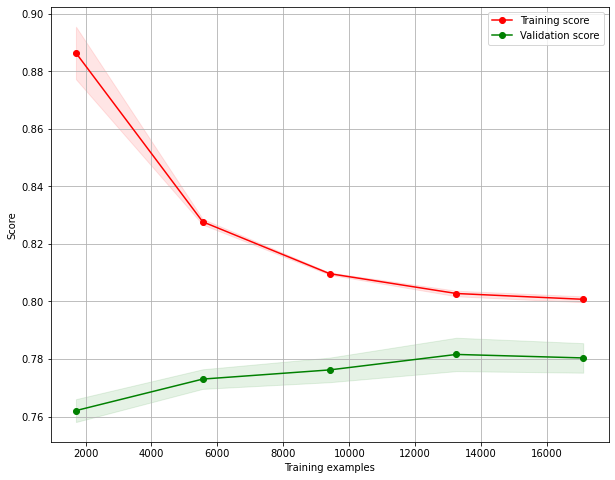

In [128]:
# plotting the learning curve

learning_curve(cat1_grid_best)

In [129]:


# Define the data and columns
data = np.array([
    ['Decision_tree', 0.997, 0.682, 0.681],
    ['Random_forest', 0.776, 0.776, 0.769],
    ['Gradient_boosting', 0.78, 0.776, 0.777],
    ['AdaBoosting', 0.767, 0.773, 0.766],
    ['XGBoost', 0.77, 0.776, 0.769],
    ['CATBoost', 0.799, 0.786, 0.780]
])

scores_df1 = pd.DataFrame(data)
scores_df1.columns = ['Model', 'Model_Train_Accuracy', 'Model_Test_Accuracy', 'Cross_Validation_Accuracy']




The elapsed time of 17 seconds for your model's prediction can be interpreted as the time taken by the model to process the given input data and generate predictions. This time includes any preprocessing, feature extraction, and computation performed by the model during the prediction step.

The interpretation of the elapsed time depends on the specific requirements and context of your deployment scenario. Here are a few aspects to consider:

1. Performance: The elapsed time can give you an indication of the computational efficiency of your model. If the prediction time is too long, it may affect the real-time responsiveness of your application or system. In such cases, you might need to optimize your model or explore alternatives to meet the performance requirements.

2. Scaling: The elapsed time can help you estimate the scalability of your model. If the prediction time is acceptable for the current workload, you can assess how the model performs when deployed in a production environment with potentially higher traffic or larger datasets.

3. User Experience: The elapsed time can impact the user experience of your application. If the prediction time is too long, it may lead to delays or perceived sluggishness. Understanding the elapsed time can help you set appropriate expectations and provide feedback to the users.

4. Model Complexity: The elapsed time can be influenced by the complexity of your model, the size of the input data, and the available computational resources. If your model has a large number of parameters or complex computations, it may result in longer prediction times. In such cases, you can explore techniques like model compression or hardware acceleration to improve the prediction speed.

It's important to note that the interpretation of the elapsed time should be evaluated in the specific context of your application and deployment requirements. You can compare the elapsed time with your performance targets or benchmarks to determine whether it meets your desired criteria.

Additionally, it is recommended to perform benchmarking and testing on representative datasets and monitor the system's performance over time to ensure it meets the required performance standards.